In [1]:
import calculate_evaluations
import importlib
import sqlite_connector

In [2]:
importlib.reload(sqlite_connector)
importlib.reload(calculate_evaluations)

dl = calculate_evaluations.data_loader(2002, 2021)
hrefs, X, y = dl.create_datasets(2004, 2019, past=2, future=2)
print(len(hrefs))
print(hrefs[-1])

3365
walt_disney


In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [4]:
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler().fit(X_train)
X_ts = scaler.transform(X_train)

print(np.mean(X_ts[:,0]))
print(np.std(X_ts[:,0]))
print(np.mean(X_ts[:,12]))
print(np.std(X_ts[:,12]))

0.0
1.0000000000000009
1.2504646999395903e-14
1.0000000000000002


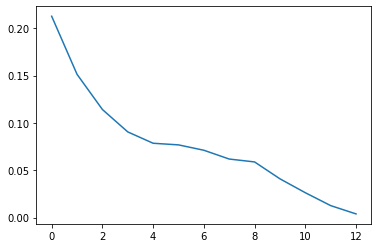

(13, 13)

0 pca vector
value in feature direction [PRR] = -0.3794736181507214
value in feature direction [INC_PE] = -0.42628826274989184
value in feature direction [CAP_Y] = -0.5036016585791115
value in feature direction [RET_Y] = -0.5268562501339352

1 pca vector
value in feature direction [PBR] = 0.6937321222742056
value in feature direction [ACT_Y] = 0.6893268608587514

2 pca vector
value in feature direction [YR_change] = 0.3625216932287838
value in feature direction [INC_PE] = -0.4178204260782243
value in feature direction [RET_PE] = -0.4530639936460651
value in feature direction [DIV_Y] = -0.5014750673975266


In [5]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
importlib.reload(calculate_evaluations)

pca = PCA().fit(X_ts)
plt.plot(np.arange(13), pca.explained_variance_ratio_)
plt.show()

pca_components = pca.components_
print(pca_components.shape)

for i in range(3):
    print(f"\n{i} pca vector")
    comp = pca_components[i]
    idxs = np.argsort(comp)
    for i in idxs[::-1]:
        if np.abs(comp[i]) > 0.32:
            print(f"value in feature direction [{calculate_evaluations.FEATURE_NAMES[i]}] = {comp[i]}")

In [6]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

parameters = {
    'C':np.linspace(0.1,10,8),
    'epsilon': np.linspace(0,0.5,8)
}

clf = GridSearchCV(SVR(), parameters, scoring='neg_mean_absolute_error', n_jobs=-1)
clf.fit(X_ts, y_train)

GridSearchCV(estimator=SVR(), n_jobs=-1,
             param_grid={'C': array([ 0.1       ,  1.51428571,  2.92857143,  4.34285714,  5.75714286,
        7.17142857,  8.58571429, 10.        ]),
                         'epsilon': array([0.        , 0.07142857, 0.14285714, 0.21428571, 0.28571429,
       0.35714286, 0.42857143, 0.5       ])},
             scoring='neg_mean_absolute_error')

-0.14613593608172049
{'C': 0.1, 'epsilon': 0.0}


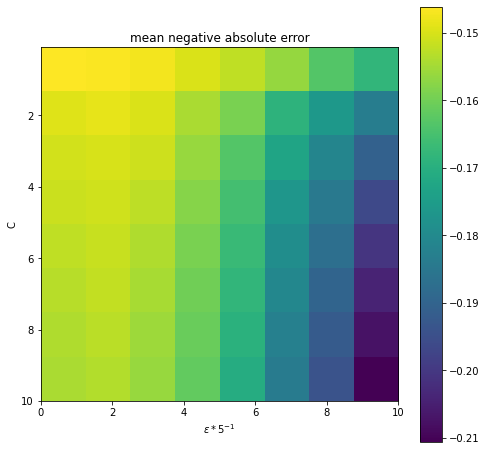

In [7]:
res = clf.cv_results_

print(clf.best_score_)
print(clf.best_params_)

scores = res['mean_test_score'].reshape(8,8)
plt.figure(figsize=(8, 8))
plt.imshow(scores, extent=[0,10,10,0.1])
#plt.imshow(scores, extent=[0.1,10,5,0])
plt.colorbar()
plt.ylabel('C')
plt.xlabel('$\epsilon * 5^{-1}$')
plt.title(f'mean negative absolute error')
plt.show()

In [8]:
from sklearn.metrics import mean_absolute_error

best_m = clf.best_estimator_

pred_train = best_m.predict(X_ts)
diff = np.abs(pred_train - y_train)
X_test_scaled = scaler.transform(X_test)
print(mean_absolute_error(y_train, pred_train))
print(mean_absolute_error(y_test, best_m.predict(X_test_scaled)))

0.13613037264206546
0.14822973807772333


In [9]:
import ml_util

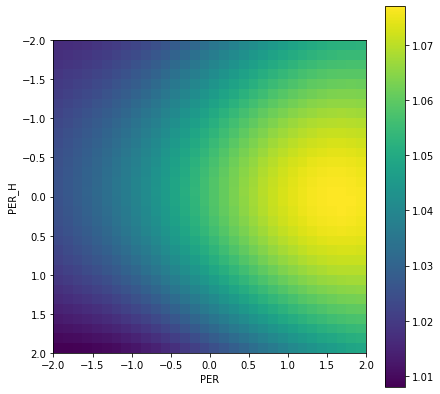

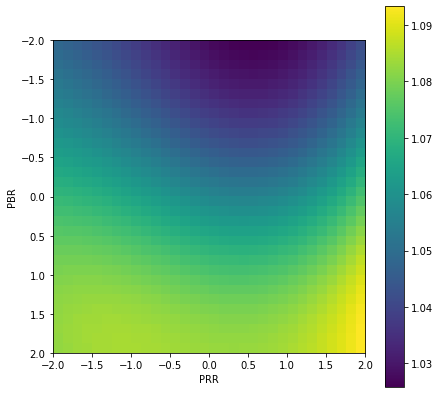

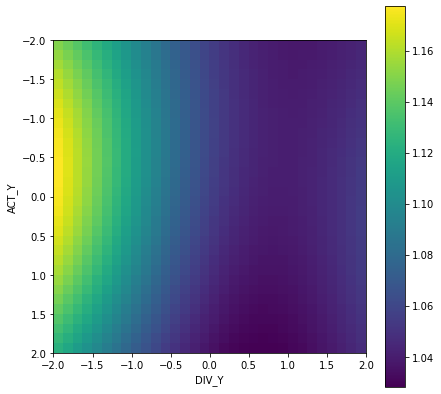

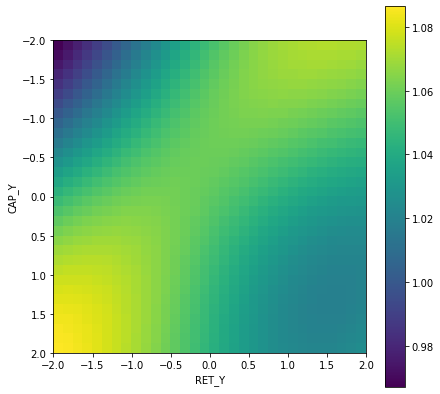

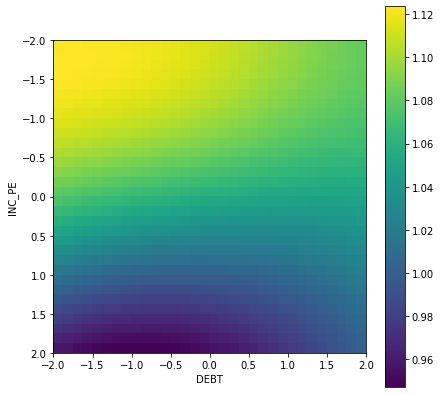

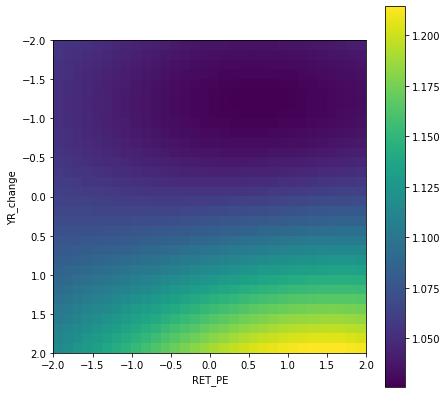

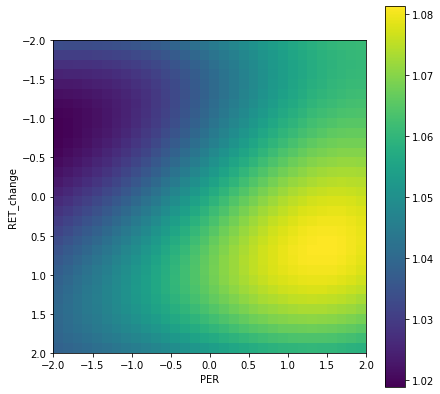

In [10]:
importlib.reload(ml_util)
for i in range(6):
    ml_util.plot_feature_pair(best_m, 2 * i, 2 * i + 1)
ml_util.plot_feature_pair(best_m, 0, 12)

In [11]:
test_data_point = np.zeros((1,13))
mean_pred = best_m.predict(test_data_point)[0]
print(f'mean_pred = {mean_pred}')
for i in range(13):
    test_data_point[0, i] = -2
    low_pred = best_m.predict(test_data_point)[0] - mean_pred
    test_data_point[0, i] =  2
    high_pred = best_m.predict(test_data_point)[0] - mean_pred
    test_data_point[0, i] =  0
    print(f'{calculate_evaluations.FEATURE_NAMES[i]} changes prediction to ([low, high]) = [{low_pred:.3f}, {high_pred:.3f}]')

mean_pred = 1.0570988021648273
PER changes prediction to ([low, high]) = [-0.032, 0.019]
PER_H changes prediction to ([low, high]) = [-0.023, -0.033]
PRR changes prediction to ([low, high]) = [0.013, 0.017]
PBR changes prediction to ([low, high]) = [-0.029, 0.026]
DIV_Y changes prediction to ([low, high]) = [0.119, -0.003]
ACT_Y changes prediction to ([low, high]) = [-0.000, -0.021]
RET_Y changes prediction to ([low, high]) = [-0.011, -0.025]
CAP_Y changes prediction to ([low, high]) = [-0.007, -0.013]
DEBT changes prediction to ([low, high]) = [0.020, -0.006]
INC_PE changes prediction to ([low, high]) = [0.055, -0.102]
RET_PE changes prediction to ([low, high]) = [0.006, 0.010]
YR_change changes prediction to ([low, high]) = [-0.021, 0.130]
RET_change changes prediction to ([low, high]) = [-0.013, -0.004]


In [12]:
from sklearn.inspection import permutation_importance
from sklearn.svm import SVR

r = permutation_importance(best_m, X_ts, y_train, n_repeats=10, random_state=42)
for i in r.importances_mean.argsort()[::-1]:
#    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
    print(f"{i:2} - {calculate_evaluations.FEATURE_NAMES[i]:<16}"
    f"{r.importances_mean[i]:.3f}"
    f" +/- {r.importances_std[i]:.3f}")

 4 - DIV_Y           0.052 +/- 0.006
11 - YR_change       0.047 +/- 0.005
12 - RET_change      0.037 +/- 0.003
 2 - PRR             0.030 +/- 0.004
 8 - DEBT            0.029 +/- 0.004
 7 - CAP_Y           0.027 +/- 0.002
 9 - INC_PE          0.024 +/- 0.004
 6 - RET_Y           0.021 +/- 0.001
10 - RET_PE          0.017 +/- 0.001
 0 - PER             0.003 +/- 0.001
 1 - PER_H           0.003 +/- 0.001
 3 - PBR             0.002 +/- 0.001
 5 - ACT_Y           0.002 +/- 0.001


In [14]:
importlib.reload(ml_util)

m_t = ml_util.load_prediction_model()
print(m_t.predict(np.zeros((1,13))))

[1.0570988]


In [17]:
y_mean = np.mean(y_train)
print(y_mean)
print(mean_absolute_error(y_train, pred_train))
diff_from_mean = np.abs(y_train - y_mean)
print(np.mean(diff_from_mean))

1.0809332671916883
0.13613037264206546
0.15656924324828578


In [19]:
from sklearn.linear_model import SGDRegressor
sgd = SGDRegressor(max_iter=1000, tol=1e-3).fit(X_ts, y_train)
pred_train = sgd.predict(X_ts)
print(mean_absolute_error(y_train, pred_train))

0.1512686212990954


In [20]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0).fit(X_ts, y_train)
pred_train = ridge.predict(X_ts)
print(mean_absolute_error(y_train, pred_train))


0.150980291959521


In [25]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=5).fit(X_ts, y_train)
pred_train = neigh.predict(X_ts)
print(mean_absolute_error(y_train, pred_train))

0.12743042607180047
